# ЛР: Прямое и обратное преобразование Радона

## Цель работы
Изучить преобразование Радона, его связь с преобразованием Фурье, а также реализовать прямое и обратное преобразование Радона в среде Python. Исследовать влияние шага углового сканирования на качество восстановления изображения.

---

## Теория

### Преобразование Радона
Преобразование Радона — это интегральное преобразование, которое сопоставляет функции, заданной на плоскости, набор её интегралов вдоль прямых. В задачах обработки изображений оно моделирует процесс получения проекций объекта при различных углах.

Совокупность проекций при разных углах образует синограмму. Преобразование Радона широко применяется в задачах компьютерной томографии и обратных задач.

---

### Связь с преобразованием Фурье (теорема о центральном срезе)
Согласно проекционно-срезовой теореме, одномерное преобразование Фурье каждой проекции Радона совпадает со значением двумерного преобразования Фурье изображения на луче частотной плоскости, проходящем через начало координат под тем же углом.

Таким образом, каждая проекция содержит информацию о срезе спектра изображения. Используя проекции под различными углами, можно восстановить исходное изображение.

---

### Обратное преобразование Радона
Восстановление изображения по проекциям осуществляется с помощью алгоритма фильтрованной обратной проекции (Filtered Backprojection, FBP).

Алгоритм включает следующие этапы:
1. Вычисление одномерного преобразования Фурье для каждой проекции.
2. Применение частотного фильтра, усиливающего высокие частоты.
3. Выполнение обратного одномерного преобразования Фурье.
4. Суммирование отфильтрованных проекций вдоль соответствующих направлений.

Данный метод реализован в библиотеке `scikit-image` в функции `iradon`.


## Практика в Python (scikit-image)


c:\Users\0potter0\AppData\Local\Programs\Python\Python312\Lib\site-packages\skimage\transform\radon_transform.py:74: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn(


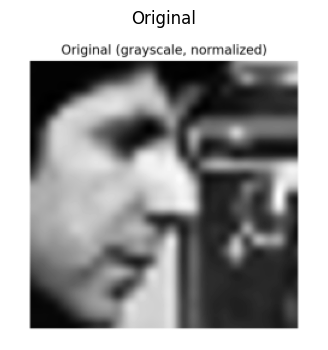

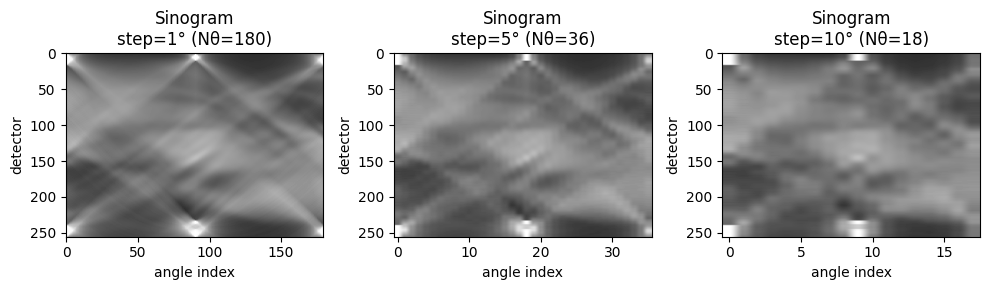

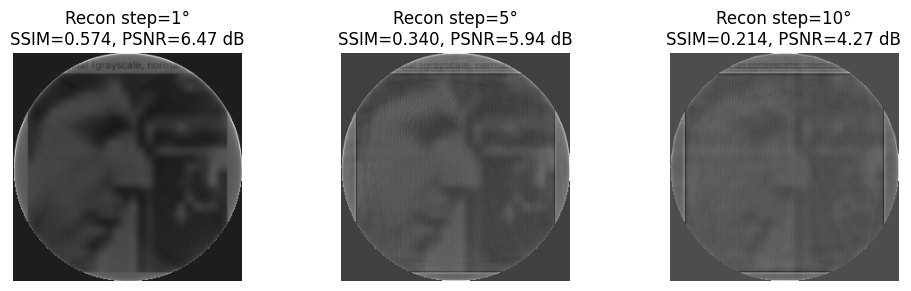

step	N_angles	MSE		PSNR	SSIM
1	180		0.225522	6.468	0.5738
5	36		0.254442	5.944	0.3398
10	18		0.373757	4.274	0.2142


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, color, img_as_float
from skimage.transform import radon, iradon, resize
from skimage.metrics import mean_squared_error, peak_signal_noise_ratio, structural_similarity

IMG_PATH = 'source.png'  # файл лежит рядом с ноутбуком

# 1-2) Загрузка, Ч/Б, нормализация
img = io.imread(IMG_PATH)

# Если RGBA — отбросить alpha-канал
if img.ndim == 3 and img.shape[2] == 4:
    img = img[:, :, :3]

# Теперь безопасно переводим в grayscale
if img.ndim == 3:
    img = color.rgb2gray(img)

img = img_as_float(img)

# Сделаем квадрат 256x256 (удобно для примера)
N = 256
img = resize(img, (N, N), anti_aliasing=True)
img = np.clip(img, 0.0, 1.0)

steps = [1, 5, 10]
results = {}

for step in steps:
    theta = np.arange(0, 180, step)
    sinogram = radon(img, theta=theta, circle=True)
    recon = iradon(sinogram, theta=theta, circle=True, filter_name='ramp')

    mse = mean_squared_error(img, recon)
    psnr = peak_signal_noise_ratio(img, recon, data_range=1.0)
    ssim = structural_similarity(img, recon, data_range=1.0)

    results[step] = dict(theta=theta, sinogram=sinogram, recon=recon, mse=mse, psnr=psnr, ssim=ssim)

# --- Визуализация ---
plt.figure(figsize=(4,4))
plt.imshow(img, cmap='gray')
plt.title('Original')
plt.axis('off')
plt.show()

plt.figure(figsize=(10,3))
for i, step in enumerate(steps, 1):
    plt.subplot(1,3,i)
    plt.imshow(results[step]['sinogram'], cmap='gray', aspect='auto')
    plt.title(f'Sinogram\nstep={step}° (Nθ={len(results[step]["theta"])})')
    plt.xlabel('angle index')
    plt.ylabel('detector')
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,3))
for i, step in enumerate(steps, 1):
    plt.subplot(1,3,i)
    r = results[step]
    plt.imshow(r["recon"], cmap='gray')
    plt.title(f'Recon step={step}°\nSSIM={r["ssim"]:.3f}, PSNR={r["psnr"]:.2f} dB')
    plt.axis('off')
plt.tight_layout()
plt.show()

print('step\tN_angles\tMSE\t\tPSNR\tSSIM')
for step in steps:
    r = results[step]
    print(f"{step}\t{len(r['theta'])}\t\t{r["mse"]:.6f}\t{r["psnr"]:.3f}\t{r["ssim"]:.4f}")
